# Game script
This section is the script to play the game

In [1]:
print("Hello")

Hello


In [1]:
'''Function to run one round of the game'''
import main2
import importlib
importlib.reload(main2)
import time
import numpy as np
import threading
import os
from tqdm import tqdm
from collections import Counter
import traceback

save_images = False
rundir = 'runs5'
os.makedirs(rundir, exist_ok=True)
def one_round(model, verbose=True):
    '''Runs one round of agar.io and returns the path to the saved images as the first element of a tuple'''
    run = f"{len(os.listdir(rundir)):0=5}"
    path = os.path.join(rundir, run)
    start_times = []
    end_times = []
    pics = []
    preped = main2.prep_for_round()
    if preped:
        main2.run_round(
            model,
            before_act=lambda *args: start_times.append(time.time()),
            after_act=lambda img: (end_times.  append(time.time()),pics.append(img)),
            timeout=5*60
        )
    else:
        raise Exception("Did not start the round")
    def make_name(i, img):
        colors = Counter(img.getdata())
        color = max(colors, key=lambda i: colors[i])
        dead = np.average(color)<240 and np.std(color)<5
        return f"{i:0=5}{'-dead' if dead else ''}.png" 
    reaction_times = [a-b for a,b in zip(end_times, start_times)]
    cycle_time = [b-a for a,b in zip(start_times[:-1], start_times[1:])]
    os.makedirs(path)
    stats = {
        "react_avg":np.average(reaction_times),
        "react_std":np.std(reaction_times),
        "cycle_avg":np.average(cycle_time),
        "cycle_std":np.std(reaction_times),
        "runtime_min":(start_times[-1]-start_times[0])/60,
        "picdir": path
    }
    if not verbose:
        if save_images:
            [img.save(os.path.join(path, make_name(i,img))) for i, img in enumerate(pics)]
    else:
        print(f'saving images')
        if save_images:
            [img.save(os.path.join(path, make_name(i,img))) for i, img in tqdm(enumerate(pics), total=len(pics))]
        print(f"Reaction average, std: {np.average(reaction_times)}, {np.std(reaction_times)}")
        print(f"Cycle average, std: {np.average(cycle_time)}, {np.std(cycle_time)}")
        print(f"Runtime: {(start_times[-1]-start_times[0])/60} minutes")
    del(pics)
    return (path,stats)

In [2]:
'''function to run n rounds of the game'''
from itertools import count
# import models.tflite_ensemble as model
import importlib
import os
from PIL import Image
import utils
import pandas as pd
from itertools import cycle

def n_rounds_with_models(n, models, onException: lambda *args: None):
    if type(models) is not list:
        models = [models]
    stat_file="stats.csv"
    df = pd.read_csv(stat_file) if os.path.exists(stat_file) else None

    s = len(os.listdir(rundir))
    for round, model in zip(count(s),cycle(models)):
        try:
            if round == s+n: break
            print(f"Round: {round:>4}")
            importlib.reload(model)
            (path,stats) = one_round(model)
            stats['name']=model.name
            df2 = pd.DataFrame(stats, [0])
            df = df2 if df is None else pd.concat([df, df2])
            df.to_csv(stat_file, index=False)

            #-------------------
            if path is None:
                print()
                continue
            pics = list(filter(lambda p: 'dead' not in p and p[-4:]=='.png', os.listdir(path)))
            os.makedirs(os.path.join(path, 'pov-cropped'))
            if not save_images: # True if not to be saved
                print()
                continue
            print("saving pov-crops")
            for p in tqdm(pics):
                img = Image.open(os.path.join(path, p))
                img = img.resize((320,200))
                x,y = model.predict(img)
                angle = np.arctan2(y,x) * 180 / np.pi
                img = utils.focus_dir(img, angle)
                img.save(os.path.join(path, 'pov-cropped', p))
            #-------------------

            print()
        except Exception as e:
            onException(e, model.name, round)
    print(f"done {n} rounds")

In [3]:
'''Script to run n rounds with different models'''
from models import random_model, random_bull, tflite_ensemble
from traceback import print_exception
import pyautogui as pag
import pandas as pd
exception_file = "exceptions.csv"
dfe = pd.read_csv(exception_file) if os.path.exists(exception_file) else pd.DataFrame(columns=['exception', 'model', 'round', 'screenshot'])
def new_exception(*args):
    dfe.loc[dfe.shape[0]] = args
    return None
exception_dir = "exception_pics"
os.makedirs(exception_dir, exist_ok=True)
n_rounds_with_models(100, [tflite_ensemble],
    lambda e, model, round: (
        print_exception(e), 
        pic:=os.path.join(
            exception_dir, 
            f"exception-{len(os.listdir(exception_dir)):0=5}.png"),
        pag.screenshot(pic),
        new_exception(e, model, round, pic),
        dfe.to_csv(exception_file, index=False)
        )
    )

Round:   36
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
Go to https://agar.io/
saving images
Reaction average, std: 0.37251805800658006, 0.030761934887877766
Cycle average, std: 0.4459509802799599, 0.03673823394084912
Runtime: 0.3790583332379659 minutes

Round:   37
Go to https://agar.io/


Traceback (most recent call last):
  File "C:\Users\rahul\AppData\Local\Temp\ipykernel_24288\1069807190.py", line 23, in n_rounds_with_models
    (path,stats) = one_round(model)
                   ^^^^^^^^^^^^^^^^
  File "C:\Users\rahul\AppData\Local\Temp\ipykernel_24288\440654737.py", line 25, in one_round
    main2.run_round(
  File "d:\Projects\Agar.io\main2.py", line 78, in run_round
    raise Exception("Could not find continue button nor play button")
Exception: Could not find continue button nor play button


Round:   38
Go to https://agar.io/


KeyboardInterrupt: 

# Records Examination
This section is to examine the recorded data from game runs

In [67]:
import pandas as pd
df = pd.read_csv("stats.csv")
df = df.loc[df.picdir.apply(lambda i: 'runs4' in i)]

In [68]:
df

,react_avg,react_std,cycle_avg,cycle_std,runtime_min,picdir,name
0,0.122368,0.008339,0.174366,0.008339,0.098807,runs4\00000,random_bull
1,0.125061,0.009572,0.180255,0.009572,0.150213,runs4\00001,random-model
2,0.266481,0.005425,0.322259,0.005425,0.075194,runs4\00002,tflite-ensemble
3,0.124128,0.008122,0.175478,0.008122,0.078965,runs4\00003,random_bull
4,0.125925,0.008526,0.183753,0.008526,0.101064,runs4\00004,random-model
...,...,...,...,...,...,...,...
624,0.121803,0.006283,0.173246,0.006283,0.317617,runs4\00628,random_bull
625,0.122381,0.008897,0.170794,0.008897,0.148022,runs4\00629,random_bull
626,0.122867,0.008628,0.177200,0.008628,0.121087,runs4\00630,random_bull
627,0.121795,0.007873,0.170944,0.007873,0.099717,runs4\00631,random_bull


In [69]:
import os
import numpy as np
dirs = df.picdir
pov_len = [len(os.listdir(os.path.join(p, 'pov-cropped'))) for p in dirs]
df2 = df.loc[np.array(pov_len)>0]

In [70]:
df2.shape

(335, 7)

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='cycle_avg', ylabel='runtime_min'>

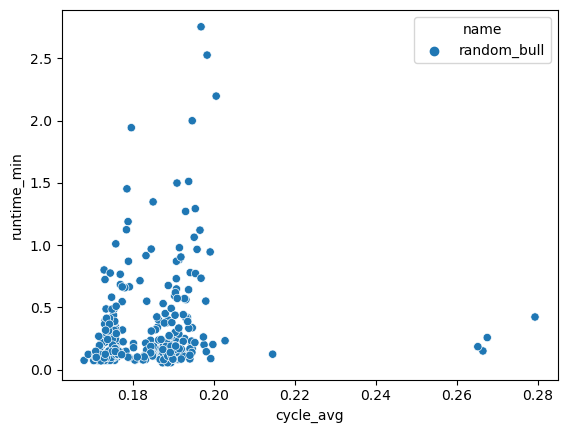

In [14]:
import seaborn as sns

sns.scatterplot(data=df2[df2.name=='random_bull'], x='cycle_avg', y='runtime_min', hue='name')

In [15]:
dfe = pd.read_csv("exceptions.csv")

In [16]:
dfe

,exception,model,round,screenshot
0,Could not find continue button nor play button,random_bull,130,exception_pics\exception-00000.png
1,Could not find continue button nor play button,random_bull,134,exception_pics\exception-00001.png
2,Could not find continue button nor play button,random_bull,135,exception_pics\exception-00002.png
3,Could not find play button,random_bull,595,exception_pics\exception-00003.png


## Just the code necessary for next sections

In [1]:
import pandas as pd
import os
import numpy as np
df = pd.read_csv("stats.csv")
df = df.loc[df.picdir.apply(lambda i: 'runs4' in i)]
dirs = df.picdir
pov_len = dirs.apply(lambda d: len(os.listdir(os.path.join(d, 'pov-cropped'))))
df2 = df.loc[np.array(pov_len)>0]

# Extracting Datasets 

In [2]:
df3 = df2.loc[df2['name']=='random_bull']
df3.shape

(308, 7)

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='runtime_min', ylabel='Count'>

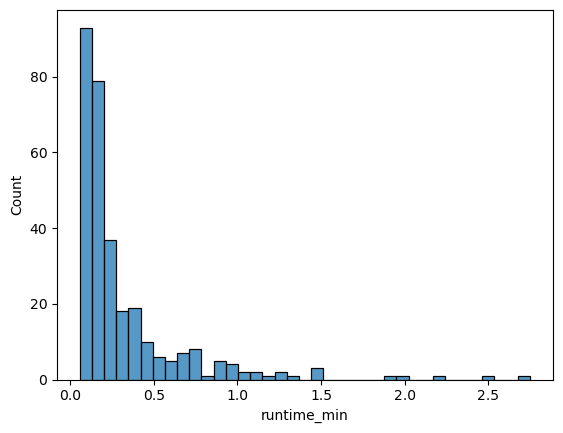

In [73]:
import seaborn as sns
sns.histplot(df3, x='runtime_min')


In [3]:
pic_dirs = df3['picdir'].apply(lambda p: os.path.join(p, 'pov-cropped'))

In [4]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(pic_dirs, test_size=0.2, random_state=42)
len(train_x), len(test_x)

(246, 62)

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

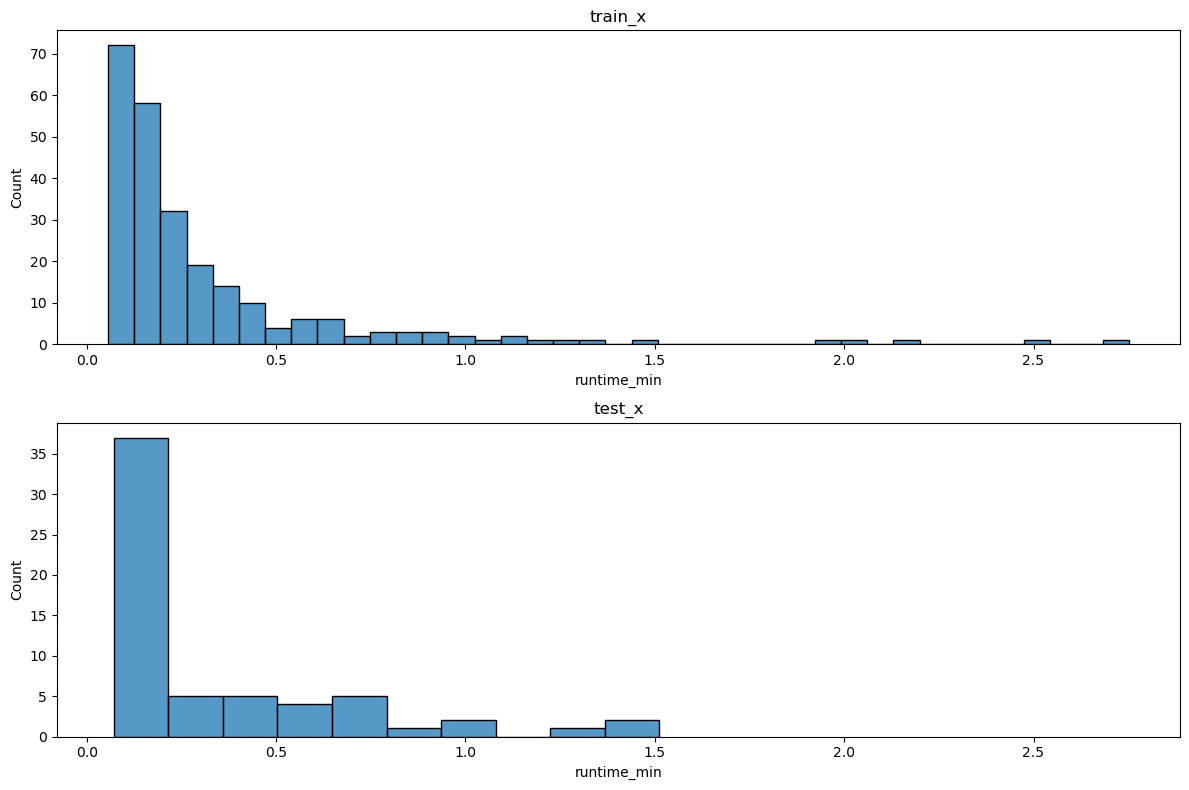

In [76]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(12,8))
sns.histplot(ax=axs[0],data=df3.loc[[i in train_x.index for i in df3.index]], x='runtime_min')
sns.histplot(ax=axs[1],data=df3.loc[[i in test_x.index for i in df3.index]], x='runtime_min')
xmins, xmaxs = zip(axs[0].get_xlim(),axs[1].get_xlim())
for ax, t in zip(axs,['train_x', 'test_x']):
    ax.set_xlim(min(xmins), max(xmaxs))
    ax.set_title(t)
plt.tight_layout()

In [5]:
def get_pic_list(dir_list, n=5):
    '''For starters well take the first 5 and last 5 pics for safe not safe'''
    all_pics = [[os.path.join(p,f) for f in os.listdir(p)] for p in dir_list]
    def split_run(run_pics):
        tot = len(run_pics)
        end = max(tot-n, 0)
        start = min(n, end)
        safe = run_pics[:start]
        death = run_pics[end:]
        return safe, death
    safe_pics, death_pics = zip(*[split_run(run) for run in all_pics])
    print(f"stats safe pics: {len(safe_pics)}, {np.average([len(i) for i in safe_pics])}")
    print(f"stats death pics: {len(death_pics)}, {np.average([len(i) for i in death_pics])}")
    return sum(safe_pics, []), sum(death_pics, [])

In [6]:
n=5
train_safe, train_death = get_pic_list(train_x, n)
test_safe, test_death = get_pic_list(test_x, n)
for i in [train_safe, train_death, test_safe, test_death]:
    print(f"{len(i)}")

stats safe pics: 246, 4.7073170731707314
stats death pics: 246, 4.930894308943089
stats safe pics: 62, 4.629032258064516
stats death pics: 62, 4.935483870967742
1158
1213
287
306


In [7]:
import tensorflow as tf

def prep_ds(safe_paths, death_paths):
    ds_safe = tf.data.Dataset.from_tensor_slices(safe_paths).map(lambda path: (path, 1))
    ds_death = tf.data.Dataset.from_tensor_slices(death_paths).map(lambda path: (path, 0))
    ds_full = ds_safe.concatenate(ds_death)
    ds_shuff = ds_full.shuffle(ds_full.cardinality())
    return ds_shuff
train_ds = prep_ds(train_safe, train_death)
test_ds = prep_ds(test_safe, test_death)

In [8]:
len(train_ds), len(test_ds)

(2371, 593)

In [82]:
list(train_ds.take(5).as_numpy_iterator())

[(b'runs4\\00563\\pov-cropped\\00000.png', 1),
 (b'runs4\\00392\\pov-cropped\\00001.png', 1),
 (b'runs4\\00332\\pov-cropped\\00047.png', 0),
 (b'runs4\\00417\\pov-cropped\\00004.png', 1),
 (b'runs4\\00585\\pov-cropped\\00269.png', 0)]

In [9]:
def map_func(path, safe):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img)
    img = tf.image.convert_image_dtype(img, tf.float16)
    safe = tf.one_hot(safe, 2, dtype=tf.float16)
    return img, safe


## Benchmarking the dataset
This benchmarking is done based on this [tensorflow doc page](https://www.tensorflow.org/guide/data_performance#reproducing_the_figures)

In [242]:
def benchmark(ds, epochs=2):
    start_time = time.perf_counter()
    print(f"Benchmarking {epochs} epochs")
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        for sample in tqdm(ds):
            time.sleep(0.01)
    print(f"Execution time: {time.perf_counter()-start_time}")

In [244]:
# Naive benchmark on dataset directly
benchmark(train_ds.map(map_func))

Benchmarking 2 epochs
Epoch: 0


100%|██████████| 2371/2371 [00:26<00:00, 89.61it/s]


Epoch: 1


100%|██████████| 2371/2371 [00:26<00:00, 89.68it/s]

Execution time: 52.8991262999989


In [286]:
# Benchmark on batched dataset
benchmark(train_ds.map(map_func).batch(50))

Benchmarking 2 epochs
Epoch: 0


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:01<00:00, 38.89it/s]


Epoch: 1


100%|██████████| 48/48 [00:01<00:00, 34.85it/s]

Execution time: 2.615411300001142


In [287]:
# Benchmark with parallel map function
benchmark(train_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).batch(50))

Benchmarking 2 epochs
Epoch: 0


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:01<00:00, 35.92it/s]


Epoch: 1


100%|██████████| 48/48 [00:01<00:00, 34.19it/s]

Execution time: 2.750941900001635


In [288]:
# Benchmark with parallel and cached map function
benchmark(train_ds
          .map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(50),
          5
          )

Benchmarking 5 epochs
Epoch: 0


100%|██████████| 48/48 [00:01<00:00, 30.97it/s]


Epoch: 1


100%|██████████| 48/48 [00:00<00:00, 77.49it/s]


Epoch: 2


100%|██████████| 48/48 [00:00<00:00, 80.19it/s]


Epoch: 3


100%|██████████| 48/48 [00:00<00:00, 79.59it/s]


Epoch: 4


100%|██████████| 48/48 [00:00<00:00, 79.51it/s]

Execution time: 3.9780271999989054


In [10]:
train2_ds = train_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(100)
test2_ds = test_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(50)

# One Block to build Dataset

In [1]:
import pandas as pd
import os
import numpy as np
df = pd.read_csv("stats.csv")
df = df.loc[df.picdir.apply(lambda i: 'runs4' in i)]
dirs = df.picdir
pov_len = dirs.apply(lambda d: len(os.listdir(os.path.join(d, 'pov-cropped'))))
df2 = df.loc[np.array(pov_len)>0]

df3 = df2.loc[df2['name']=='random_bull']

pic_dirs = df3['picdir'].apply(lambda p: os.path.join(p, 'pov-cropped'))

from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(pic_dirs, test_size=0.2, random_state=42)

def get_pic_list(dir_list, n=5):
    '''For starters well take the first 5 and last 5 pics for safe not safe'''
    all_pics = [[os.path.join(p,f) for f in os.listdir(p)] for p in dir_list]
    def split_run(run_pics):
        tot = len(run_pics)
        end = max(tot-n, 0)
        start = min(n, end)
        safe = run_pics[:start]
        death = run_pics[end:]
        return safe, death
    safe_pics, death_pics = zip(*[split_run(run) for run in all_pics])
    print(f"stats safe pics: {len(safe_pics)}, {np.average([len(i) for i in safe_pics])}")
    print(f"stats death pics: {len(death_pics)}, {np.average([len(i) for i in death_pics])}")
    return sum(safe_pics, []), sum(death_pics, [])

n=5
train_safe, train_death = get_pic_list(train_x, n)
test_safe, test_death = get_pic_list(test_x, n)

import tensorflow as tf

def prep_ds(safe_paths, death_paths):
    ds_safe = tf.data.Dataset.from_tensor_slices(safe_paths).map(lambda path: (path, 1))
    ds_death = tf.data.Dataset.from_tensor_slices(death_paths).map(lambda path: (path, 0))
    ds_full = ds_safe.concatenate(ds_death)
    ds_shuff = ds_full.shuffle(ds_full.cardinality())
    return ds_shuff
train_ds = prep_ds(train_safe, train_death)
test_ds = prep_ds(test_safe, test_death)

def map_func(path, safe):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img)
    img = tf.image.convert_image_dtype(img, tf.float16)
    safe = tf.one_hot(safe, 2, dtype=tf.float16)
    return img, safe

train2_ds = train_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(100)
test2_ds = test_ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(50)

stats safe pics: 246, 4.7073170731707314
stats death pics: 246, 4.930894308943089
stats safe pics: 62, 4.629032258064516
stats death pics: 62, 4.935483870967742


In [142]:
data_aug = tf.keras.Sequential(layers=[
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomBrightness(0.002),
    tf.keras.layers.RandomContrast(0.5)
])

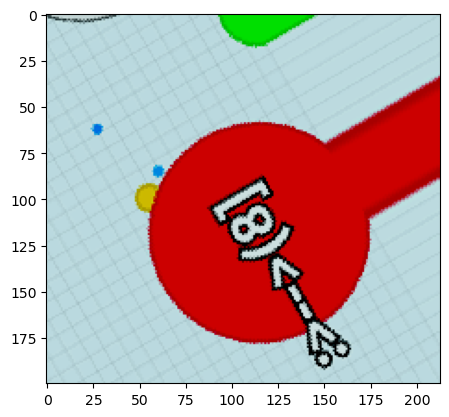

In [158]:
import matplotlib.pyplot as plt
plt.imshow(
    tf.cast(
        next(train2_ds.map(lambda i,j:(data_aug(i), j)).take(1).as_numpy_iterator())[0][0],
        tf.float32
    )
)

# Creating/Training Model

## Hyperparameter selection

### Model Structure

In [60]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_CONV_LAYERS  = hp.HParam("num_conv_layers", hp.Discrete([1,2,]))
HP_CONV_FILTERS = hp.HParam("num_conv_filters", hp.Discrete([16, 32, 64]))
HP_DENSE_LAYERS = hp.HParam("struct_dense_layers", hp.Discrete(["2", "10 2", "100 10 2"]))

METRIC_ACCURACY = 'accuracy'

# with tf.summary.create_file_writer("tb_logs\\hparam_tuning").as_default():
#     hp.hparams_config(
#         hparams=[HP_CONV_LAYERS, HP_CONV_FILTERS, HP_DENSE_LAYERS],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy")]
#     )

In [75]:
Sequential = tf.keras.Sequential
layers = tf.keras.layers
def train_test_model(hparams):
    input_layer = layers.Input(shape=(200, 213, 3))
    conv_layers = [
        [layers.Conv2D(hparams[HP_CONV_FILTERS], 5), layers.MaxPooling2D(5)] for _ in range(hparams[HP_CONV_LAYERS])
    ]
    conv_layers = sum(conv_layers, [])
    dense_layers = hparams[HP_DENSE_LAYERS]
    dense_layers = dense_layers.split(" ")
    dense_layers = [int(i) for i in dense_layers]
    dense_layers = [
        layers.Dense(i, 'relu' if i!=2 else 'softmax') for i in dense_layers
    ]
    model = Sequential(layers=[
        input_layer,
        *conv_layers,
        layers.Flatten(),
        *dense_layers,
    ])
    model.compile(
        'adam',
        tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
        jit_compile=True
    )
    hist = model.fit(
        train2_ds,
        validation_data=test2_ds,
        epochs=4
    )
    return hist
    # print(model.summary())
    # print()

In [76]:
def all_comb(*args):
    def combine(x, y):
        a = x
        b = y
        c = []
        for _a in a:
            for _b in b:
                c.append((*_a,_b))
        return c
    sol = [(i,) for i in args[0]]
    for b in args[1:]:
        sol = combine(sol, b)
    return sol

    
    

In [77]:
from tqdm import tqdm
histories = {}
for conv_layers, conv_filters, dense_layers in (all_comb(*[i.domain.values for i in [HP_CONV_LAYERS, HP_CONV_FILTERS, HP_DENSE_LAYERS]])):
    hparams = {
        HP_CONV_LAYERS: conv_layers,
        HP_CONV_FILTERS: conv_filters,
        HP_DENSE_LAYERS: dense_layers
    }
    model_name = '-'.join([str(i) for i in [conv_layers, conv_filters, dense_layers]])
    model_name = model_name.replace(" ", "_")
    print(model_name)
    histories[model_name] = train_test_model(hparams)



1-16-10_2
Epoch 1/3
24/24 [==============================] - 41s 2s/step - loss: 0.9230 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 2/3
24/24 [==============================] - 38s 2s/step - loss: 0.6931 - accuracy: 0.5116 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 3/3
24/24 [==============================] - 41s 2s/step - loss: 0.6931 - accuracy: 0.5116 - val_loss: 0.6931 - val_accuracy: 0.5160
1-16-100_10_2
Epoch 1/3
24/24 [==============================] - 44s 2s/step - loss: 0.8372 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 2/3
24/24 [==============================] - 43s 2s/step - loss: 0.6931 - accuracy: 0.5116 - val_loss: 0.6930 - val_accuracy: 0.5160
Epoch 3/3
24/24 [==============================] - 43s 2s/step - loss: 0.6931 - accuracy: 0.5116 - val_loss: 0.6930 - val_accuracy: 0.5160
1-16-2
Epoch 1/3
24/24 [==============================] - 42s 2s/step - loss: 0.7447 - accuracy: 0.6453 - val_loss: 0.6105 - val_accuracy: 0.6

In [83]:
df = None
for k in histories:
    df2 = pd.DataFrame(histories[k].history)
    df2['model'] = k
    df = df2 if df is None else pd.concat([df, df2])
df.to_csv("grid_search.csv", index=False)

In [84]:
df = pd.read_csv("grid_search.csv")

In [125]:
dfs = df.groupby('model')
df_list = []
for model, _df in dfs:
    print(model)
    _df = _df.reset_index(drop=True)[['loss', 'val_loss', 'accuracy', 'val_accuracy']].stack().reset_index().rename({'level_0':'Epoch', 'level_1':'Metric', 0:'Value'}, axis=1)
    _df['Model'] = model
    print(_df)
    df_list.append(_df)
dfs = pd.concat(df_list)

1-16-100_10_2
    Epoch        Metric     Value          Model
0       0          loss  0.837246  1-16-100_10_2
1       0      val_loss  0.693070  1-16-100_10_2
2       0      accuracy  0.505694  1-16-100_10_2
3       0  val_accuracy  0.516020  1-16-100_10_2
4       1          loss  0.693083  1-16-100_10_2
5       1      val_loss  0.693029  1-16-100_10_2
6       1      accuracy  0.511598  1-16-100_10_2
7       1  val_accuracy  0.516020  1-16-100_10_2
8       2          loss  0.693057  1-16-100_10_2
9       2      val_loss  0.692991  1-16-100_10_2
10      2      accuracy  0.511598  1-16-100_10_2
11      2  val_accuracy  0.516020  1-16-100_10_2
1-16-10_2
    Epoch        Metric     Value      Model
0       0          loss  0.923041  1-16-10_2
1       0      val_loss  0.693115  1-16-10_2
2       0      accuracy  0.500633  1-16-10_2
3       0  val_accuracy  0.516020  1-16-10_2
4       1          loss  0.693120  1-16-10_2
5       1      val_loss  0.693092  1-16-10_2
6       1      accuracy 

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

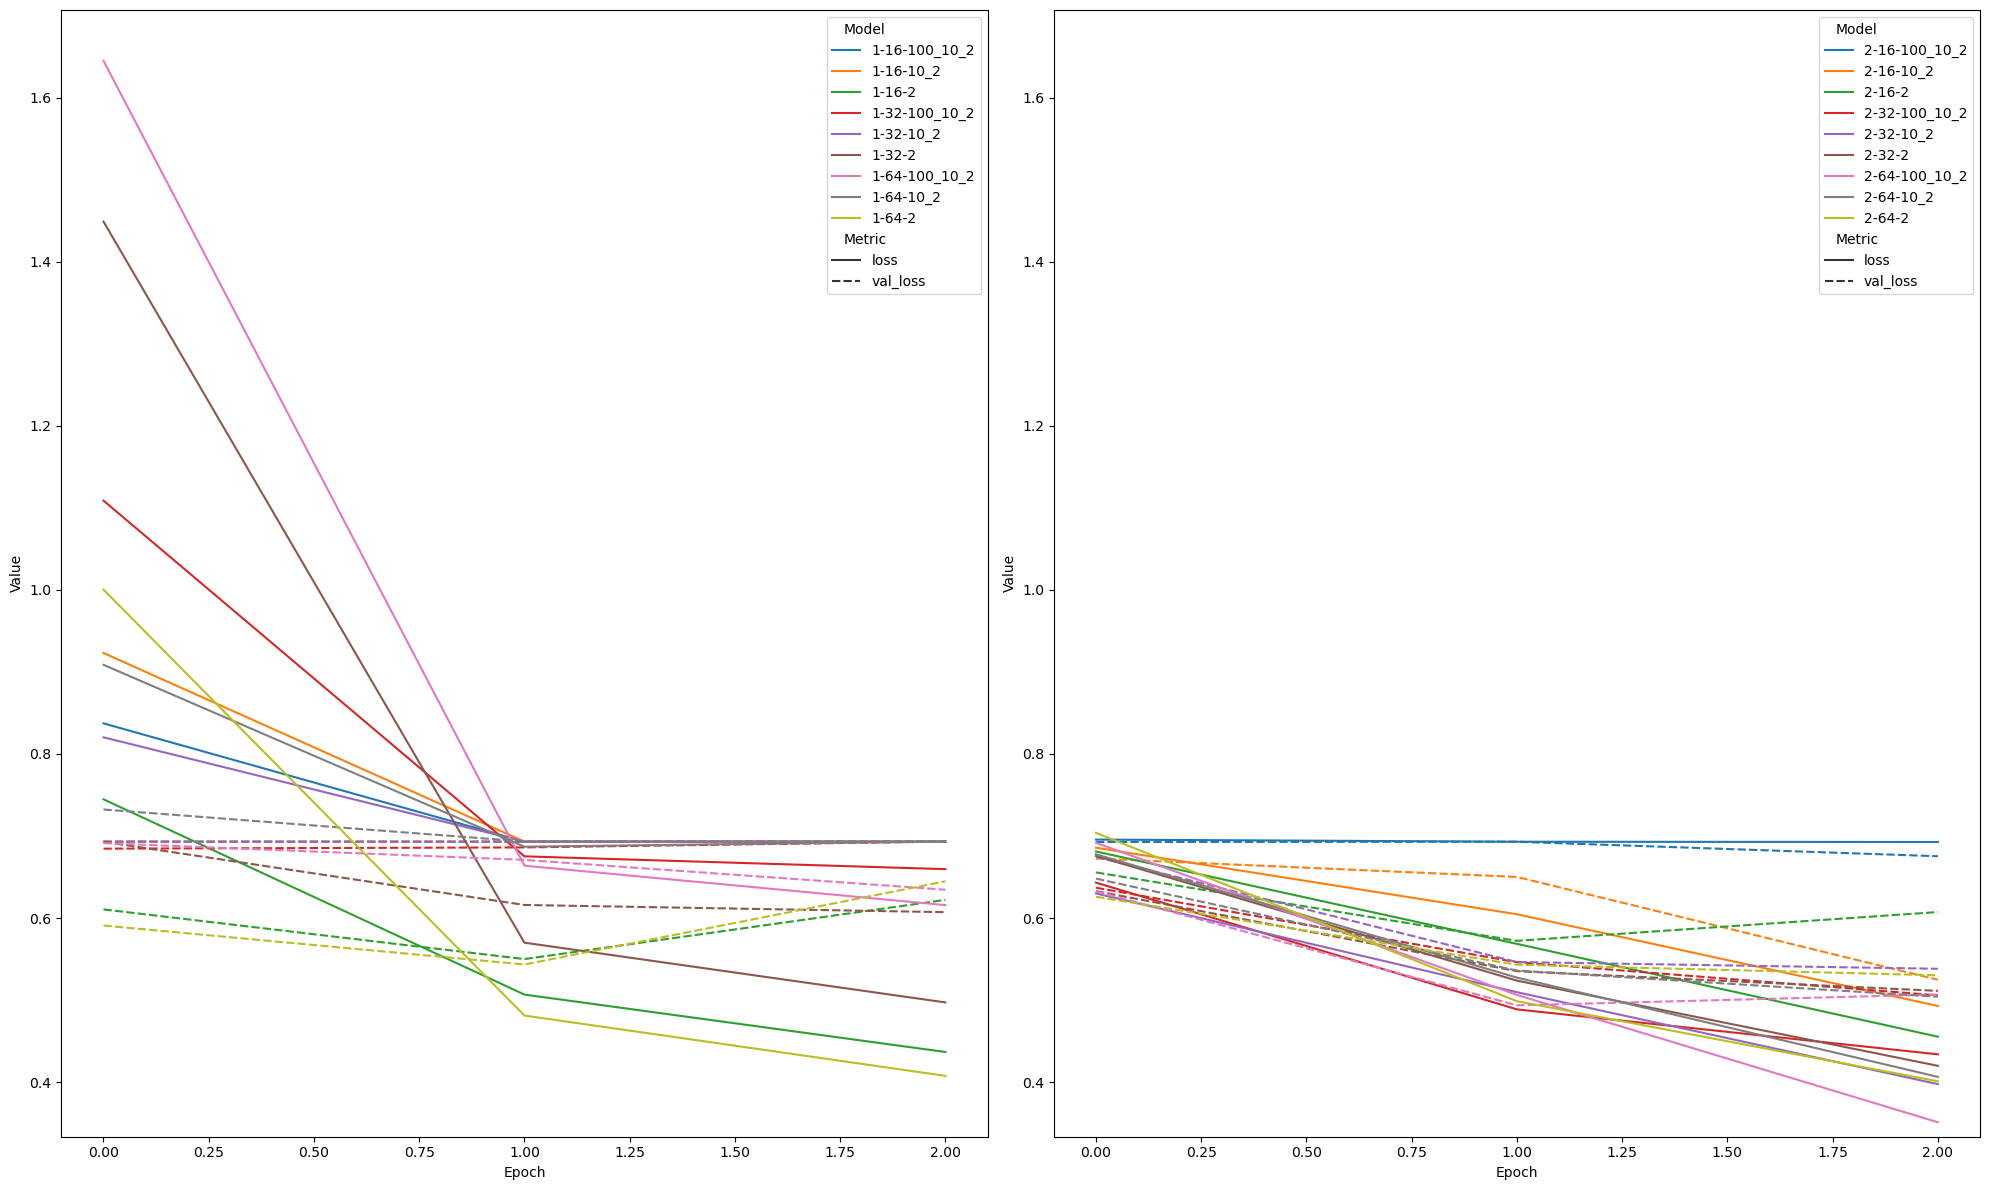

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(1,2,figsize=(20,12))
ymins = []
ymaxs = []
plt.subplot(121)
filter_index = (dfs['Model'].apply(lambda m: m[0]=='1') & dfs['Metric'].apply(lambda m: 'loss' in m))
sns.lineplot(data=dfs.loc[filter_index], x='Epoch', y='Value', hue='Model', style='Metric')
ymins.append(plt.ylim()[0])
ymaxs.append(plt.ylim()[1])
plt.subplot(122)
filter_index = (dfs['Model'].apply(lambda m: m[0]=='2') & dfs['Metric'].apply(lambda m: 'loss' in m))
sns.lineplot(data=dfs.loc[filter_index], x='Epoch', y='Value', hue='Model', style='Metric')
ymins.append(plt.ylim()[0])
ymaxs.append(plt.ylim()[1])
plt.ylim(min(ymins), max(ymaxs))
plt.subplot(121)
plt.ylim(min(ymins), max(ymaxs))
plt.tight_layout()

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='Epoch', ylabel='Value'>

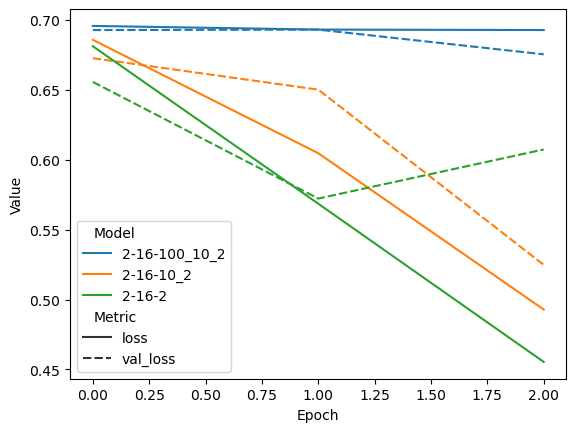

In [147]:
filter_index = (dfs['Model'].apply(lambda m: '2-16' in m and m[0]=='2') & dfs['Metric'].apply(lambda m: 'loss' in m))
sns.lineplot(data=dfs.loc[filter_index], x='Epoch', y='Value', hue='Model', style='Metric')

### Model Regularization

In [163]:
Sequential = tf.keras.Sequential
layers = tf.keras.layers
new_model = lambda reg=None: tf.keras.Sequential(layers=[
    layers.Input((200,213,3)),
    layers.Conv2D(16, 5),
    layers.MaxPooling2D(5),
    layers.Conv2D(16, 5),
    layers.MaxPooling2D(5),
    layers.Flatten(),
    layers.Dense(10, activation='relu', kernel_regularizer=reg),
    layers.Dense(2, activation='softmax', kernel_regularizer=reg)
])

In [164]:
model = new_model()
model.summary()

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_209 (Conv2D)         (None, 196, 209, 16)      1216      
                                                                 
 max_pooling2d_209 (MaxPool  (None, 39, 41, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_210 (Conv2D)         (None, 35, 37, 16)        6416      
                                                                 
 max_pooling2d_210 (MaxPool  (None, 7, 7, 16)          0         
 ing2D)                                                          
                                                                 
 flatten_129 (Flatten)       (None, 784)               0         
                                                                 
 dense_158 (Dense)           (None, 10)             

In [169]:
metrics = tf.keras.metrics
dfs_list = []
for reg in ['l1', 'l2', 'l1_l2', None]:
    model = new_model(reg)
    model.compile('adam',
                tf.keras.losses.BinaryCrossentropy(),
                [
                    "accuracy",
                    metrics.Precision(),
                    metrics.Recall(),
                    metrics.F1Score()
                ],
                jit_compile=True)
    print(f"Fitting with Regularization: {str(reg)}")
    hist = model.fit(
        train2_ds,
        validation_data=test2_ds,
        epochs=10
    )
    df = pd.DataFrame(hist.history)
    df['regularization'] = str(reg)
    dfs_list.append(df)
dfs = pd.concat(dfs)


Fitting with Regularization: l1
Epoch 1/10
24/24 [==============================] - 72s 3s/step - loss: 3.4800 - accuracy: 0.5820 - precision_9: 0.5820 - recall_9: 0.5820 - f1_score: 0.5736 - val_loss: 2.7689 - val_accuracy: 0.7066 - val_precision_9: 0.7066 - val_recall_9: 0.7066 - val_f1_score: 0.6988
Epoch 2/10
24/24 [==============================] - 62s 3s/step - loss: 2.2132 - accuracy: 0.7448 - precision_9: 0.7448 - recall_9: 0.7448 - f1_score: 0.7391 - val_loss: 1.7282 - val_accuracy: 0.7605 - val_precision_9: 0.7605 - val_recall_9: 0.7605 - val_f1_score: 0.7576
Epoch 3/10
24/24 [==============================] - 58s 2s/step - loss: 1.3381 - accuracy: 0.8064 - precision_9: 0.8064 - recall_9: 0.8064 - f1_score: 0.8060 - val_loss: 1.1366 - val_accuracy: 0.7757 - val_precision_9: 0.7757 - val_recall_9: 0.7757 - val_f1_score: 0.7748
Epoch 4/10
24/24 [==============================] - 58s 2s/step - loss: 0.9391 - accuracy: 0.8330 - precision_9: 0.8330 - recall_9: 0.8330 - f1_score: 0

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [193]:
def drop_num(df: pd.DataFrame):
    columns = df.columns
    def rename(name):
        lst = name.split("_")
        if lst[-1].isnumeric():
            lst = lst[:-1]
        return "_".join(lst)
    d = {c:rename(c) for c in columns}
    return df.rename(d, axis=1)

In [199]:
pd.concat(drop_num(df) for df in dfs_list).to_csv("regularization_histories.csv", index=False)

In [92]:
import pandas as pd
df = pd.read_csv("regularization_histories.csv")
df = df.fillna("None")

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='epoch', ylabel='loss'>

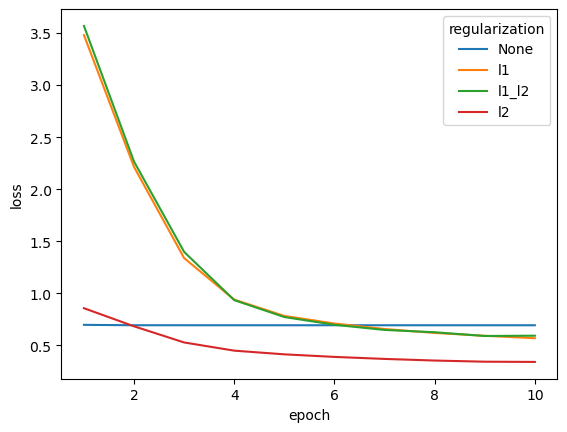

In [94]:
import seaborn as sns
# sns.lineplot(df[['loss', 'regularization']], hue='regularization')
dfs = []
for grp, _df in df.groupby("regularization"):
    _df['epoch'] = [1+i for i in range(_df.shape[0])]
    dfs.append(_df)
sns.lineplot(pd.concat(dfs), x='epoch', y='loss', hue='regularization')


d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='epoch', ylabel='loss'>

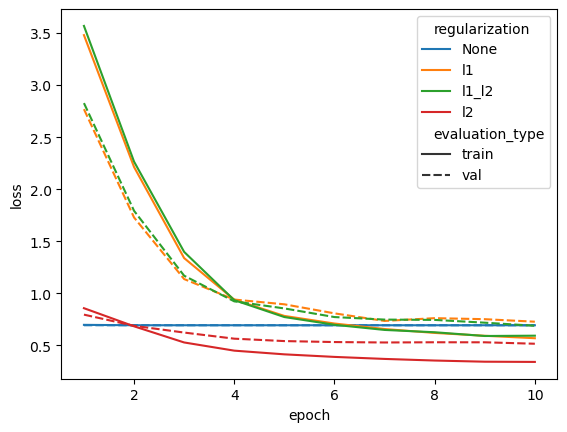

In [95]:
df2 = pd.concat(dfs)
train_cols = [col for col in df2.columns if 'val' not in col]
val_cols = [col for col in df2.columns if 'val' in col]
train_df = df2[train_cols]
train_df.loc[:, ['evaluation_type']] = 'train'
val_df = df2[val_cols+['regularization', 'epoch']].rename(lambda i: i[4:] if i[:3]=='val' else i, axis=1)
val_df.loc[:, ['evaluation_type']] = 'val'
df2 = pd.concat([train_df, val_df])
sns.lineplot(df2, x='epoch', y='loss', hue='regularization', style='evaluation_type')

In [96]:
df2.columns

Index(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'regularization',
       'epoch', 'evaluation_type'],
      dtype='object')

### Model Dropout Rate

In [11]:
import tensorflow as tf
Sequential = tf.keras.Sequential
layers = tf.keras.layers
new_model = lambda drop_out, reg='l2': tf.keras.Sequential(layers=[
    layers.Input((200,213,3)),
    layers.Conv2D(16, 5),
    layers.MaxPooling2D(5),
    layers.Conv2D(16, 5),
    layers.MaxPooling2D(5),
    layers.Flatten(),
    layers.Dropout(drop_out),
    layers.Dense(10, activation='relu', kernel_regularizer=reg),
    layers.Dropout(drop_out),
    layers.Dense(2, activation='softmax', kernel_regularizer=reg)
])

In [58]:
model = new_model(0.5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 209, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 41, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 37, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0

In [12]:
metrics = tf.keras.metrics
dfs_list = []
for drop in [0.0, 0.25, 0.5, 0.75]:
    model = new_model(drop)
    model.compile('adam',
                tf.keras.losses.BinaryCrossentropy(),
                [
                    "accuracy",
                    metrics.Precision(),
                    metrics.Recall(),
                    metrics.F1Score()
                ],
                jit_compile=True)
    print(f"Fitting with dropout rate: {str(drop)}")
    hist = model.fit(
        train2_ds,
        validation_data=test2_ds,
        epochs=10
    )
    df = pd.DataFrame(hist.history)
    df['regularization'] = str("l2")
    df['dropout'] = str(drop)
    df = df.rename(lambda j: "_".join(j.split("_")[:-1]) if j.split("_")[-1].isnumeric() else j, axis=1)
    df.loc[:, ['epoch']] = df.index
    dfs_list.append(df)
    dfs = pd.concat(dfs_list)
    dfs.to_csv("drop_out_history.csv", index=False)


Fitting with dropout rate: 0.0
Epoch 1/10
24/24 [==============================] - 36s 1s/step - loss: 0.8975 - accuracy: 0.5150 - precision: 0.5150 - recall: 0.5150 - f1_score: 0.5121 - val_loss: 0.8513 - val_accuracy: 0.5666 - val_precision: 0.5666 - val_recall: 0.5666 - val_f1_score: 0.5122
Epoch 2/10
24/24 [==============================] - 31s 1s/step - loss: 0.7905 - accuracy: 0.6099 - precision: 0.6099 - recall: 0.6099 - f1_score: 0.6096 - val_loss: 0.8054 - val_accuracy: 0.5734 - val_precision: 0.5734 - val_recall: 0.5734 - val_f1_score: 0.5067
Epoch 3/10
24/24 [==============================] - 32s 1s/step - loss: 0.6930 - accuracy: 0.6849 - precision: 0.6849 - recall: 0.6849 - f1_score: 0.6847 - val_loss: 0.7345 - val_accuracy: 0.6560 - val_precision: 0.6560 - val_recall: 0.6560 - val_f1_score: 0.6256
Epoch 4/10
24/24 [==============================] - 31s 1s/step - loss: 0.5905 - accuracy: 0.7760 - precision: 0.7760 - recall: 0.7760 - f1_score: 0.7755 - val_loss: 0.6464 - va

In [27]:
train_cols = [i for i in dfs.columns if 'val' not in i]
val_cols = dfs.columns[5:]
train_dfs = dfs.loc[:, train_cols]
train_dfs.loc[:, ['evaluation_type']] = 'train'
val_dfs = dfs.loc[:, val_cols]
val_dfs = val_dfs.rename(lambda i: i[4:] if i[:3]=='val' else i, axis=1)
val_dfs.loc[:, ['evaluation_type']] = 'val'
dfs2 = pd.concat([train_dfs, val_dfs])

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='epoch', ylabel='loss'>

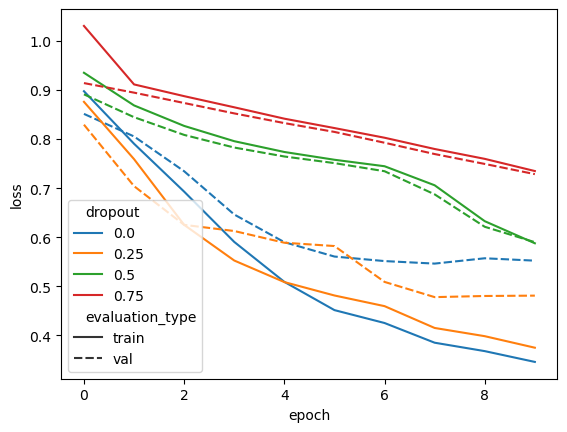

In [31]:
import seaborn as sns
sns.lineplot(dfs2, x='epoch', y='loss', hue='dropout', style='evaluation_type')

In [32]:
metrics = tf.keras.metrics
metrics = tf.keras.metrics
dfs_list = []
for drop in [0.1, 0.15, 0.2]:
    model = new_model(drop)
    model.compile('adam',
                tf.keras.losses.BinaryCrossentropy(),
                [
                    "accuracy",
                    metrics.Precision(),
                    metrics.Recall(),
                    metrics.F1Score()
                ],
                jit_compile=True)
    print(f"Fitting with dropout rate: {str(drop)}")
    hist = model.fit(
        train2_ds,
        validation_data=test2_ds,
        epochs=10
    )
    df = pd.DataFrame(hist.history)
    df['regularization'] = str("l2")
    df['dropout'] = str(drop)
    df = df.rename(lambda j: "_".join(j.split("_")[:-1]) if j.split("_")[-1].isnumeric() else j, axis=1)
    df.loc[:, ['epoch']] = df.index
    dfs_list.append(df)
    dfs = pd.concat(dfs_list)
    dfs.to_csv("drop_out_history2.csv", index=False)

Fitting with dropout rate: 0.1
Epoch 1/10
24/24 [==============================] - 33s 1s/step - loss: 0.8943 - accuracy: 0.5230 - precision_4: 0.5230 - recall_4: 0.5230 - f1_score: 0.4774 - val_loss: 0.8540 - val_accuracy: 0.5160 - val_precision_4: 0.5160 - val_recall_4: 0.5160 - val_f1_score: 0.3404
Epoch 2/10
24/24 [==============================] - 36s 1s/step - loss: 0.8048 - accuracy: 0.6179 - precision_4: 0.6179 - recall_4: 0.6179 - f1_score: 0.6058 - val_loss: 0.7795 - val_accuracy: 0.6796 - val_precision_4: 0.6796 - val_recall_4: 0.6796 - val_f1_score: 0.6708
Epoch 3/10
24/24 [==============================] - 36s 2s/step - loss: 0.7229 - accuracy: 0.7022 - precision_4: 0.7022 - recall_4: 0.7022 - f1_score: 0.7022 - val_loss: 0.7131 - val_accuracy: 0.7470 - val_precision_4: 0.7470 - val_recall_4: 0.7470 - val_f1_score: 0.7415
Epoch 4/10
24/24 [==============================] - 38s 2s/step - loss: 0.6196 - accuracy: 0.7849 - precision_4: 0.7849 - recall_4: 0.7849 - f1_score: 0.

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='epoch', ylabel='loss'>

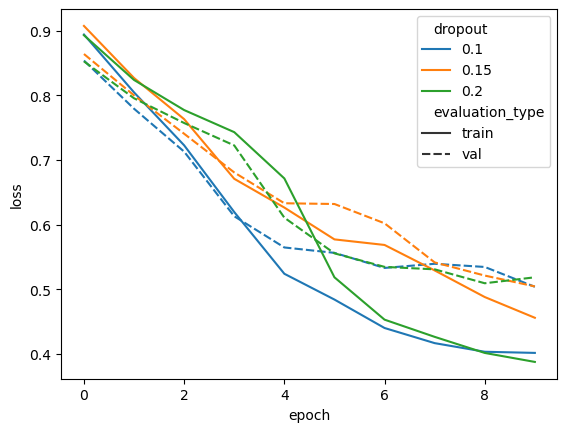

In [35]:
train_cols = [i for i in dfs.columns if 'val' not in i]
val_cols = dfs.columns[5:]
train_dfs = dfs.loc[:, train_cols]
train_dfs.loc[:, ['evaluation_type']] = 'train'
val_dfs = dfs.loc[:, val_cols]
val_dfs = val_dfs.rename(lambda i: i[4:] if i[:3]=='val' else i, axis=1)
val_dfs.loc[:, ['evaluation_type']] = 'val'
dfs2 = pd.concat([train_dfs, val_dfs])
sns.lineplot(dfs2, x='epoch', y='loss', hue='dropout', style='evaluation_type')

I'll go with dropt rate of 0.15

### Trying another model

In [159]:
import tensorflow as tf
Sequential = tf.keras.Sequential
layers = tf.keras.layers
new_model = lambda drop_out, reg='l2': tf.keras.Sequential(layers=[
    layers.Input((200,213,3)),
    layers.Conv2D(64, 5),
    layers.MaxPooling2D(5),
    layers.Conv2D(64, 5),
    layers.MaxPooling2D(5),
    layers.Flatten(),
    layers.Dropout(drop_out),
    layers.Dense(100, activation='relu', kernel_regularizer=reg),
    layers.Dropout(drop_out),
    layers.Dense(10, activation='relu', kernel_regularizer=reg),
    layers.Dropout(drop_out),
    layers.Dense(2, activation='softmax', kernel_regularizer=reg)
])

In [161]:
def train_model(*args):
    model = new_model(*args)
    model.compile('adam',
                tf.keras.losses.BinaryCrossentropy(),
                ["accuracy"],
                jit_compile=True)
    print(f"Fitting with args {args}")
    hist = model.fit(
        train2_ds.map(lambda i,j: (data_aug(i),j)).cache(),
        validation_data=test2_ds,
        epochs=20,
        callbacks=tf.keras.callbacks.EarlyStopping()
    )
    df = pd.DataFrame(hist.history)
    df['args'] = str(args)
    return df

In [162]:
arg_list = [(0.1,), (0.2,), (0.3,), (0.4,)]
df_list = []
for args in arg_list:
    df = train_model(*args)
    df_list.append(df)

Fitting with args (0.1,)
Epoch 1/20
24/24 [==============================] - 151s 6s/step - loss: 2.1862 - accuracy: 0.5086 - val_loss: 1.5663 - val_accuracy: 0.5160
Epoch 2/20
24/24 [==============================] - 109s 5s/step - loss: 1.2820 - accuracy: 0.5124 - val_loss: 1.0680 - val_accuracy: 0.5160
Epoch 3/20
24/24 [==============================] - 111s 5s/step - loss: 0.9780 - accuracy: 0.5209 - val_loss: 0.9045 - val_accuracy: 0.5160
Epoch 4/20
24/24 [==============================] - 106s 4s/step - loss: 0.8901 - accuracy: 0.5124 - val_loss: 0.8629 - val_accuracy: 0.5160
Epoch 5/20
24/24 [==============================] - 106s 4s/step - loss: 0.8353 - accuracy: 0.5112 - val_loss: 0.8043 - val_accuracy: 0.5160
Epoch 6/20
24/24 [==============================] - 106s 4s/step - loss: 0.7885 - accuracy: 0.5297 - val_loss: 0.7723 - val_accuracy: 0.5481
Epoch 7/20
24/24 [==============================] - 106s 4s/step - loss: 0.7444 - accuracy: 0.6221 - val_loss: 0.7710 - val_accur

In [174]:
df = pd.concat(df_list)

In [ ]:
df.to_csv("Saving_this_file_for_later.csv")

In [197]:
df[['loss', 'val_loss', 'args']].stack().reset_index().pivot(columns='level1', )

,level_0,level_1,0
0,0,loss,2.186234
1,0,val_loss,1.566317
2,0,args,"(0.1,)"
3,1,loss,1.282
4,1,val_loss,1.068025
...,...,...,...
103,8,val_loss,0.602908
104,8,args,"(0.4,)"
105,9,loss,0.554492
106,9,val_loss,0.624354


In [173]:
import seaborn as sns
sns.lineplot(
    pd.concat(df_list)[['loss', 'args']],
    x='loss',
    y=range(11),
    hue='args'
)

ValueError: Length of range vectors must match length of `data` when both are used, but `data` has length 36 and the vector passed to `y` has length 11.

## Building and training model

In [36]:
model = new_model(0.15)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 196, 209, 16)      1216      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 39, 41, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 35, 37, 16)        6416      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dropout_14 (Dropout)        (None, 784)              

In [45]:
model = new_model(0.3)
model.compile('adam',
            tf.keras.losses.BinaryCrossentropy(),
            [
                "accuracy",
                metrics.Precision(),
                metrics.Recall(),
                metrics.F1Score()
            ],
            jit_compile=True)

hist = model.fit(
    train2_ds,
    validation_data=test2_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping()]
)

Epoch 1/50
24/24 [==============================] - 31s 1s/step - loss: 0.8638 - accuracy: 0.5525 - precision_11: 0.5528 - recall_11: 0.5521 - f1_score: 0.5421 - val_loss: 0.8145 - val_accuracy: 0.7218 - val_precision_11: 0.7218 - val_recall_11: 0.7218 - val_f1_score: 0.7217
Epoch 2/50
24/24 [==============================] - 29s 1s/step - loss: 0.7418 - accuracy: 0.7069 - precision_11: 0.7069 - recall_11: 0.7069 - f1_score: 0.7065 - val_loss: 0.6895 - val_accuracy: 0.7707 - val_precision_11: 0.7707 - val_recall_11: 0.7707 - val_f1_score: 0.7680
Epoch 3/50
24/24 [==============================] - 29s 1s/step - loss: 0.6224 - accuracy: 0.7849 - precision_11: 0.7849 - recall_11: 0.7849 - f1_score: 0.7849 - val_loss: 0.6078 - val_accuracy: 0.7858 - val_precision_11: 0.7858 - val_recall_11: 0.7858 - val_f1_score: 0.7857
Epoch 4/50
24/24 [==============================] - 29s 1s/step - loss: 0.5475 - accuracy: 0.8009 - precision_11: 0.8009 - recall_11: 0.8009 - f1_score: 0.8009 - val_loss: 

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: >

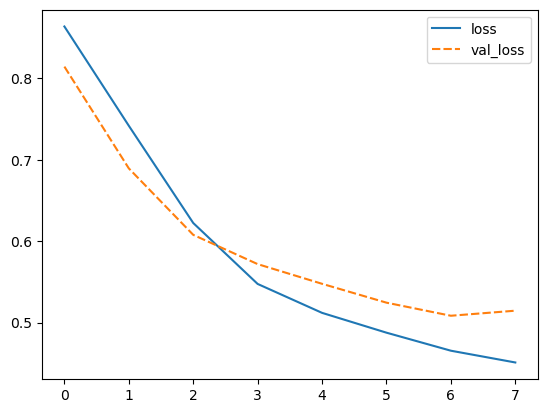

In [46]:
history = pd.DataFrame(hist.history)
sns.lineplot(history[['loss', 'val_loss']])